# Real-World Example: Smoothing Water Bodies from Raster Data

This notebook demonstrates how to use Smoothify on real water body polygons derived from raster satellite imagery

## Dataset Information
- **File**: `Water.gpkg`
- **Features**: 625 water body polygons
- **Source**: Polygonised from the S1S2 Water dataset 

## Setup

In [1]:
import time

import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from smoothify import smoothify

# Set up plotting style
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.size"] = 10

## Load the Dataset

In [2]:
# Load the water bodies GeoPackage
water_gdf = gpd.read_file("Water.gpkg")

## Visualize the Original Dataset

Let's see what the pixelated water bodies look like before smoothing.

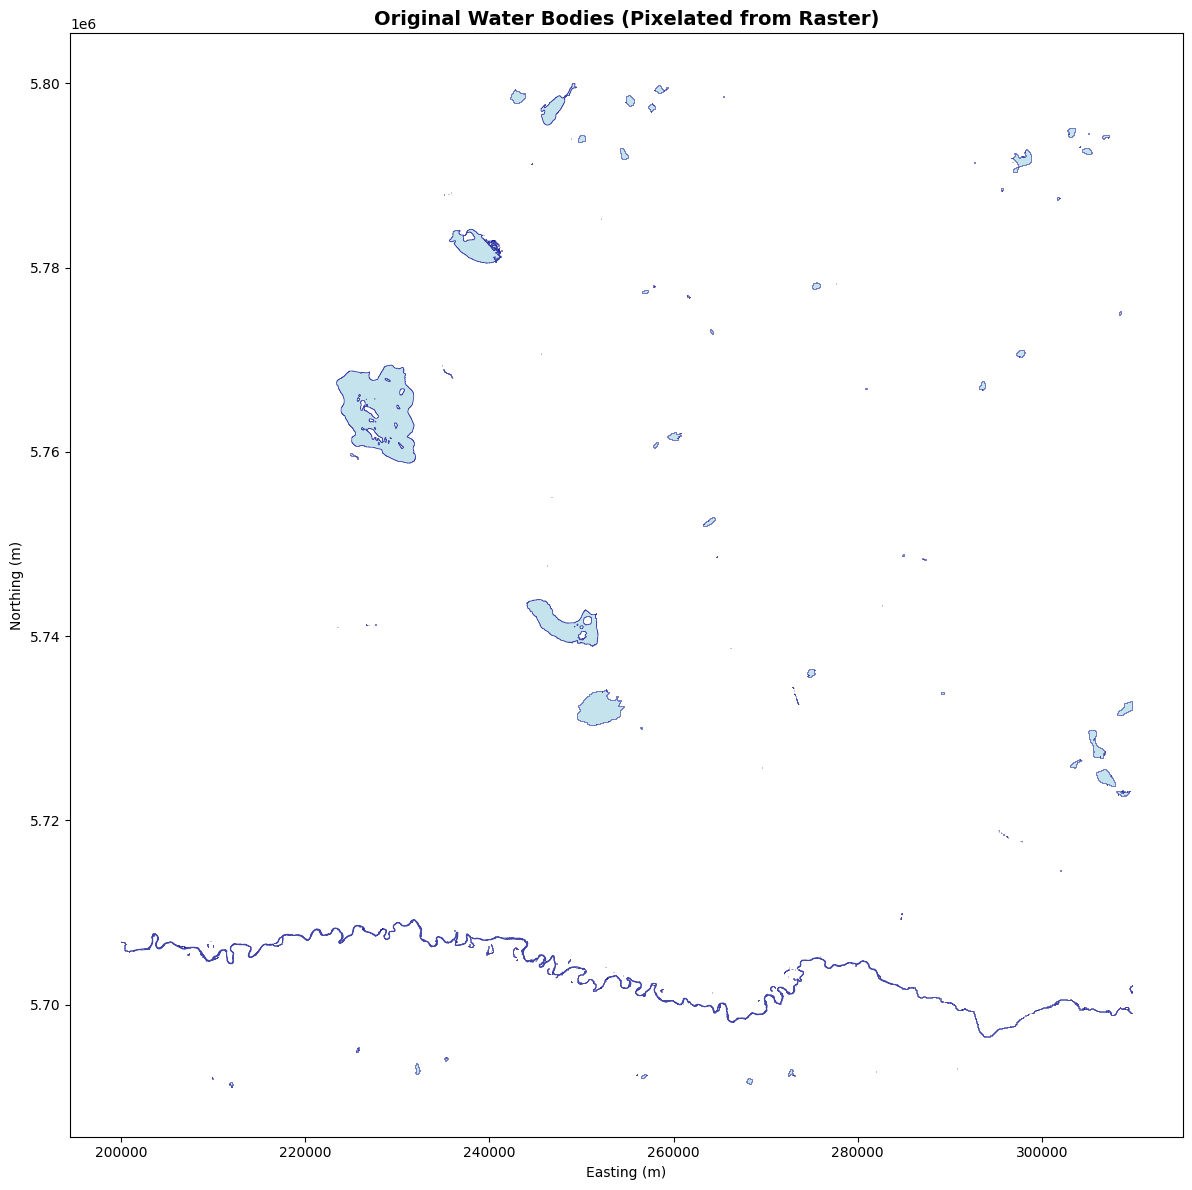

In [3]:
fig, ax = plt.subplots(figsize=(15, 12))
water_gdf.plot(ax=ax, color="lightblue", edgecolor="darkblue", linewidth=0.5, alpha=0.7)
ax.set_title(
    "Original Water Bodies (Pixelated from Raster)", fontsize=14, fontweight="bold"
)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

## Close-up View: Before Smoothing

Let's zoom in on a few water bodies to clearly see the pixelated edges.

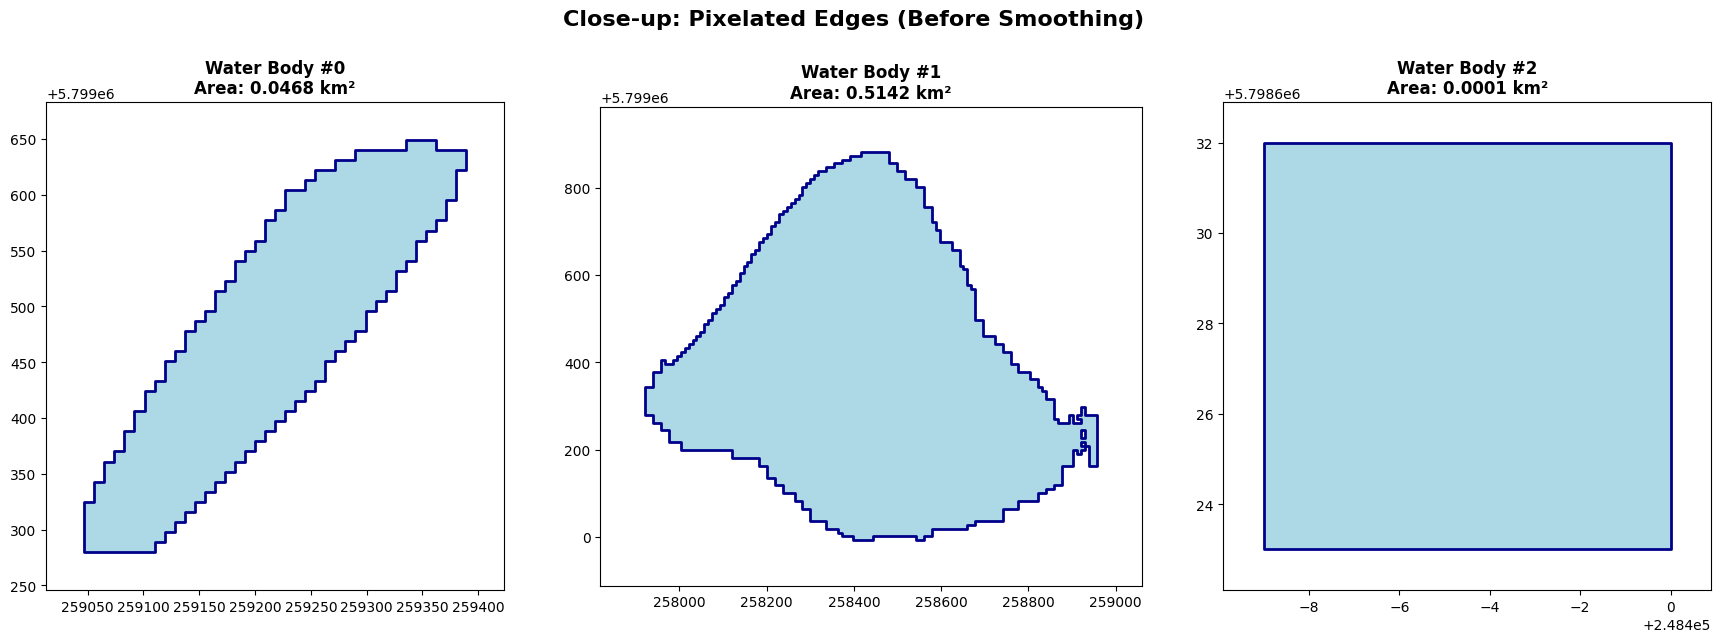

In [4]:
# Select a few representative water bodies of different sizes
sample_indices = water_gdf.index[0:3]  # Get 3 largest water bodies
sample_water = water_gdf.loc[sample_indices]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (i, row) in enumerate(sample_water.iterrows()):
    ax = axes[idx]
    gpd.GeoSeries([row.geometry]).plot(
        ax=ax, color="lightblue", edgecolor="darkblue", linewidth=2
    )
    ax.set_title(
        f"Water Body #{i}\nArea: {row.geometry.area / 1e6:.4f} km²", fontweight="bold"
    )
    ax.set_aspect("equal")

    # Add zoom to show pixelation clearly
    bounds = row.geometry.bounds
    margin = (bounds[2] - bounds[0]) * 0.1
    ax.set_xlim(bounds[0] - margin, bounds[2] + margin)
    ax.set_ylim(bounds[1] - margin, bounds[3] + margin)

plt.suptitle(
    "Close-up: Pixelated Edges (Before Smoothing)",
    fontsize=16,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

## Apply Smoothing

Now let's smooth the entire dataset using Smoothify. We'll use:
- **segment_length**: 10m as the data is from Sentinel-2 satellite imagery
- **smooth_iterations**: 3 (good balance between smoothness and processing time)
- **num_cores**: 0 (use all available CPU cores for parallel processing)
- **preserve_area**: True (maintain original water body areas)
- **merge_multipolygons**: False (don't merge adjacent polygons within MultiPolygons)
- **merge_collection**: False (don't merge adjacent polygons within GeometryCollections)

In [5]:
# Smooth the entire dataset
print("Smoothing 625 water bodies...")
start_time = time.time()

smoothed_water_gdf = smoothify(
    geom=water_gdf,
    segment_length=10,
    smooth_iterations=3,
    num_cores=0,  # Use all available cores
    preserve_area=True,  # Maintain original areas
    merge_multipolygons=False,  # Don't merge adjacent polygons
    merge_collection=False,  # Don't merge adjacent geometries
)

elapsed_time = time.time() - start_time

print("\n✓ Smoothing complete!")
print(f"  Processing time: {elapsed_time:.2f} seconds")
print(f"  Average time per feature: {elapsed_time / len(water_gdf):.3f} seconds")
print("\nArea comparison:")
print(f"  Original total area: {water_gdf.area.sum() / 1e6:.4f} km²")
print(f"  Smoothed total area: {smoothed_water_gdf.area.sum() / 1e6:.4f} km²")
print(
    f"  Area difference: {abs(water_gdf.area.sum() - smoothed_water_gdf.area.sum()) / water_gdf.area.sum() * 100:.3f}%"  # noqa: E501
)

Smoothing 625 water bodies...

✓ Smoothing complete!
  Processing time: 1.65 seconds
  Average time per feature: 0.003 seconds

Area comparison:
  Original total area: 138.4581 km²
  Smoothed total area: 138.4604 km²
  Area difference: 0.002%


## Visualize Smoothed Results

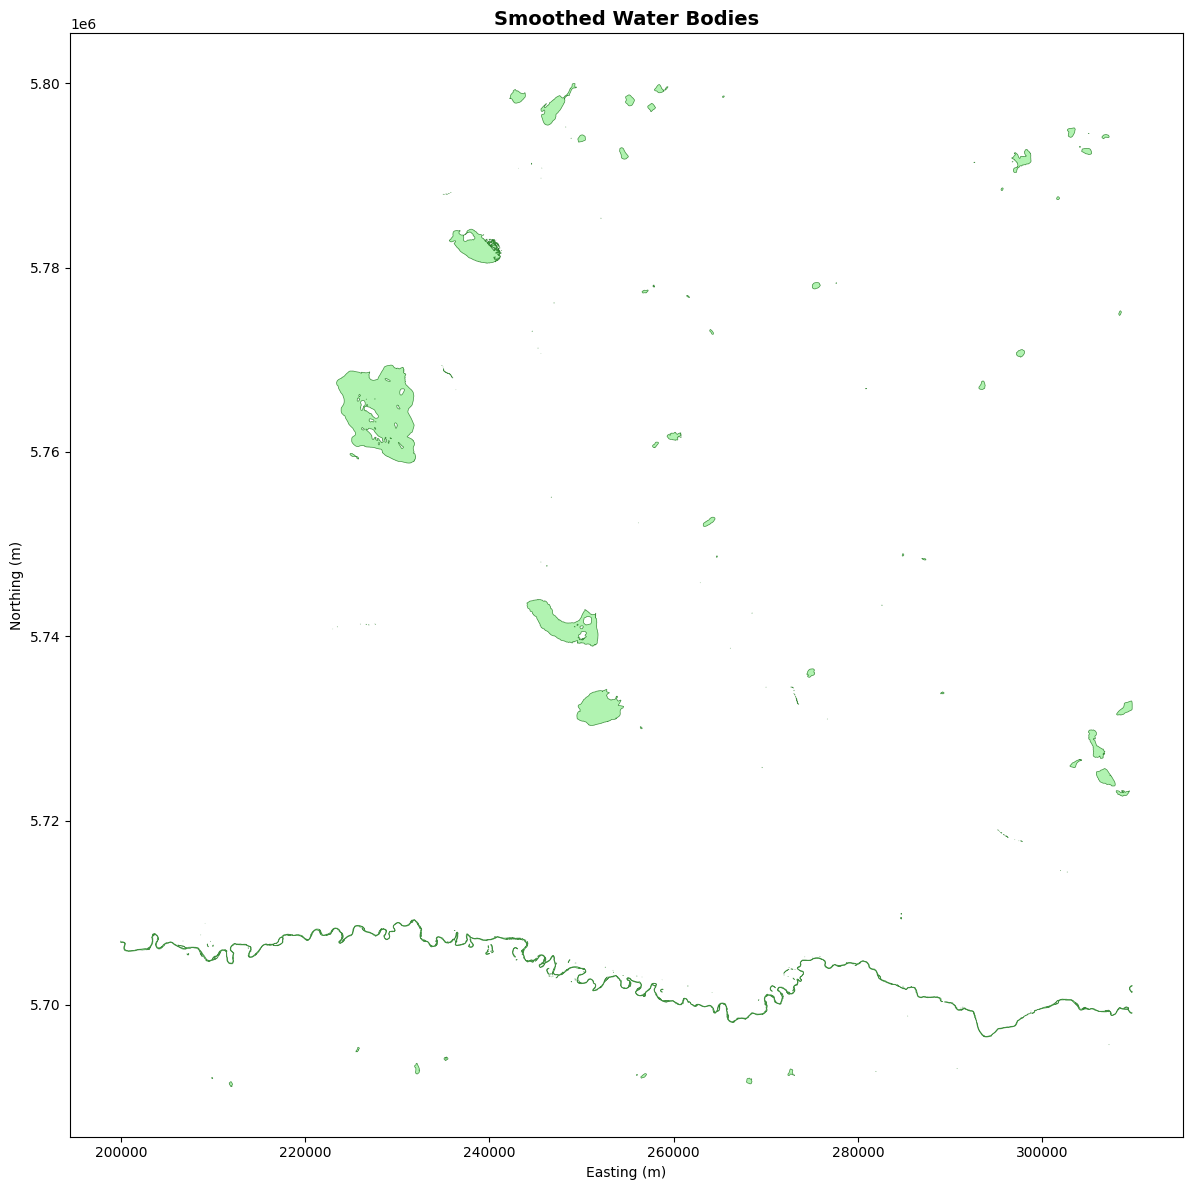

In [6]:
fig, ax = plt.subplots(figsize=(15, 12))
smoothed_water_gdf.plot(
    ax=ax, color="lightgreen", edgecolor="darkgreen", linewidth=0.5, alpha=0.7
)
ax.set_title("Smoothed Water Bodies", fontsize=14, fontweight="bold")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

## Side-by-Side Comparison

Let's compare the original and smoothed versions side by side.

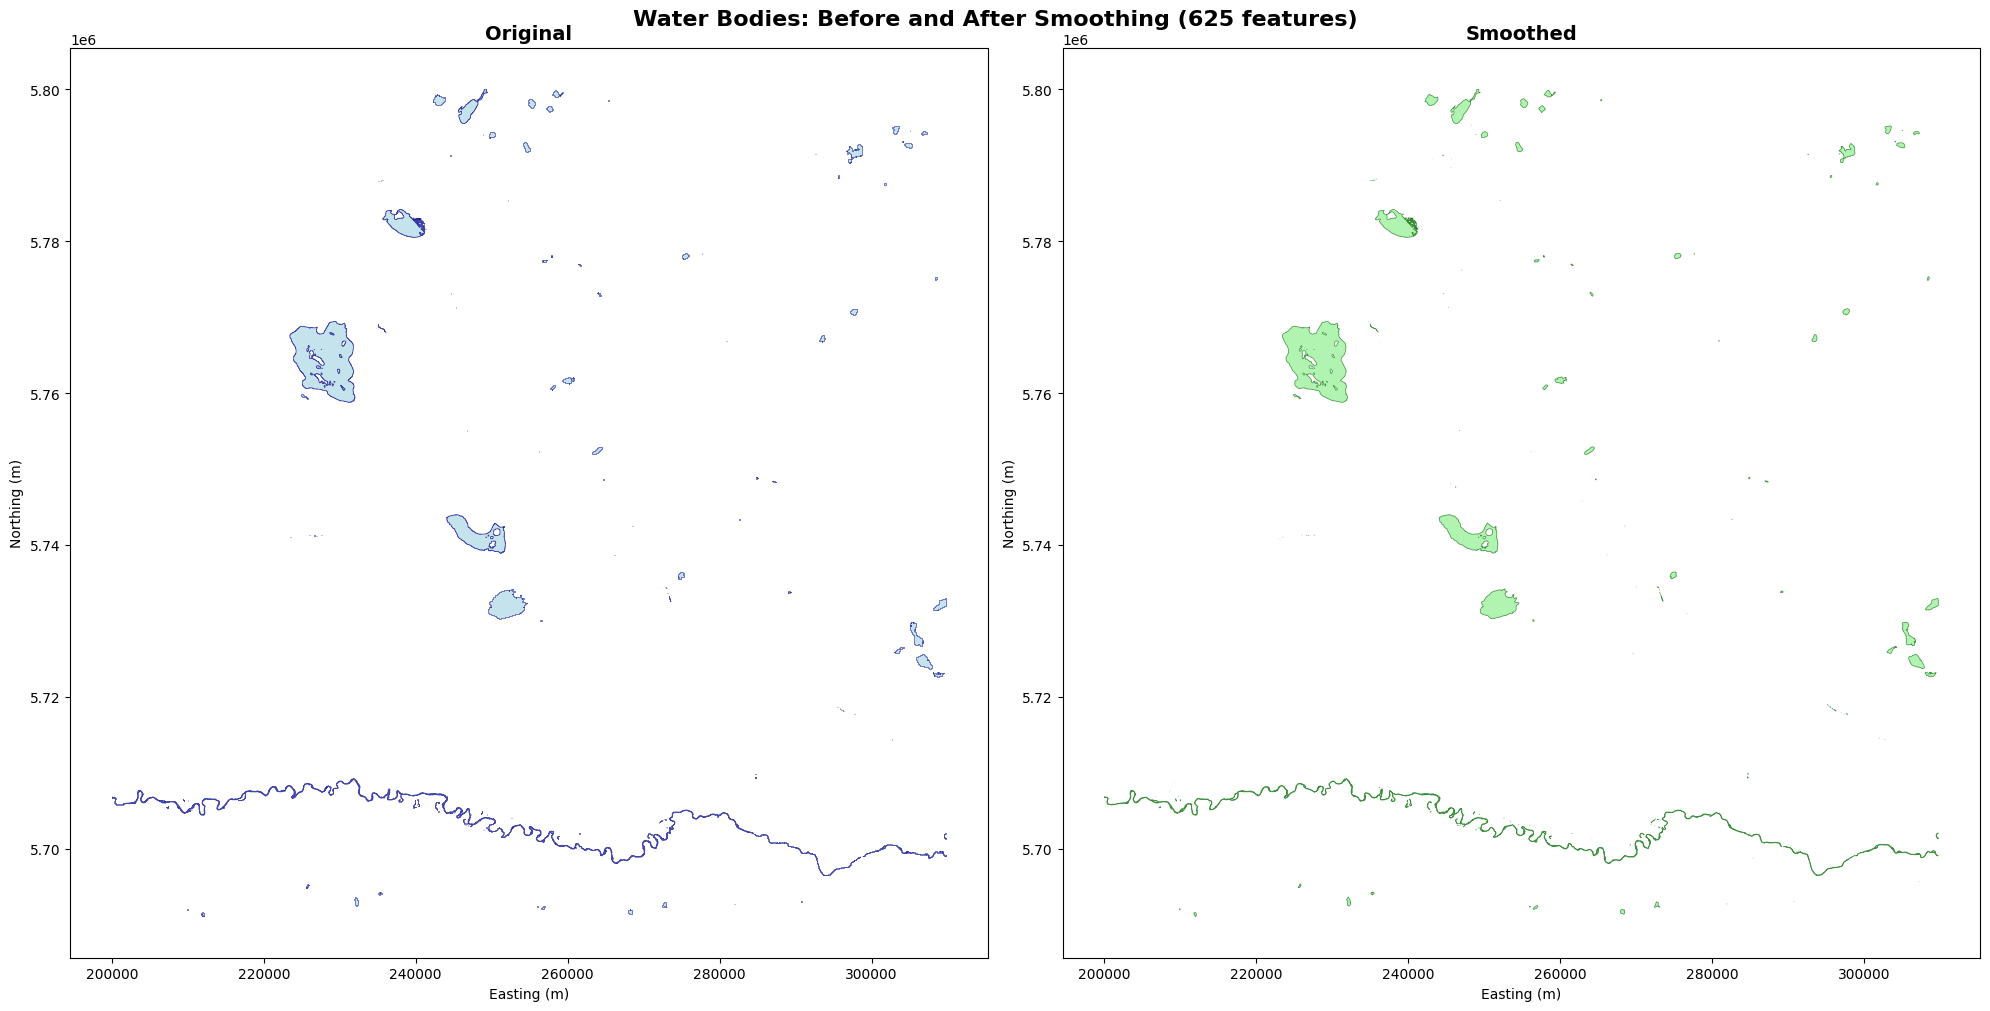

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Original
water_gdf.plot(
    ax=ax1, color="lightblue", edgecolor="darkblue", linewidth=0.5, alpha=0.7
)
ax1.set_title("Original", fontsize=14, fontweight="bold")
ax1.set_xlabel("Easting (m)")
ax1.set_ylabel("Northing (m)")

# Smoothed
smoothed_water_gdf.plot(
    ax=ax2, color="lightgreen", edgecolor="darkgreen", linewidth=0.5, alpha=0.7
)
ax2.set_title("Smoothed", fontsize=14, fontweight="bold")
ax2.set_xlabel("Easting (m)")
ax2.set_ylabel("Northing (m)")

plt.suptitle(
    f"Water Bodies: Before and After Smoothing ({len(water_gdf)} features)",
    fontsize=16,
    fontweight="bold",
    y=0.98,
)
plt.tight_layout()
plt.show()

## Detailed Close-up Comparison

Let's zoom in on the same water bodies we looked at earlier to see the smoothing effect in detail.

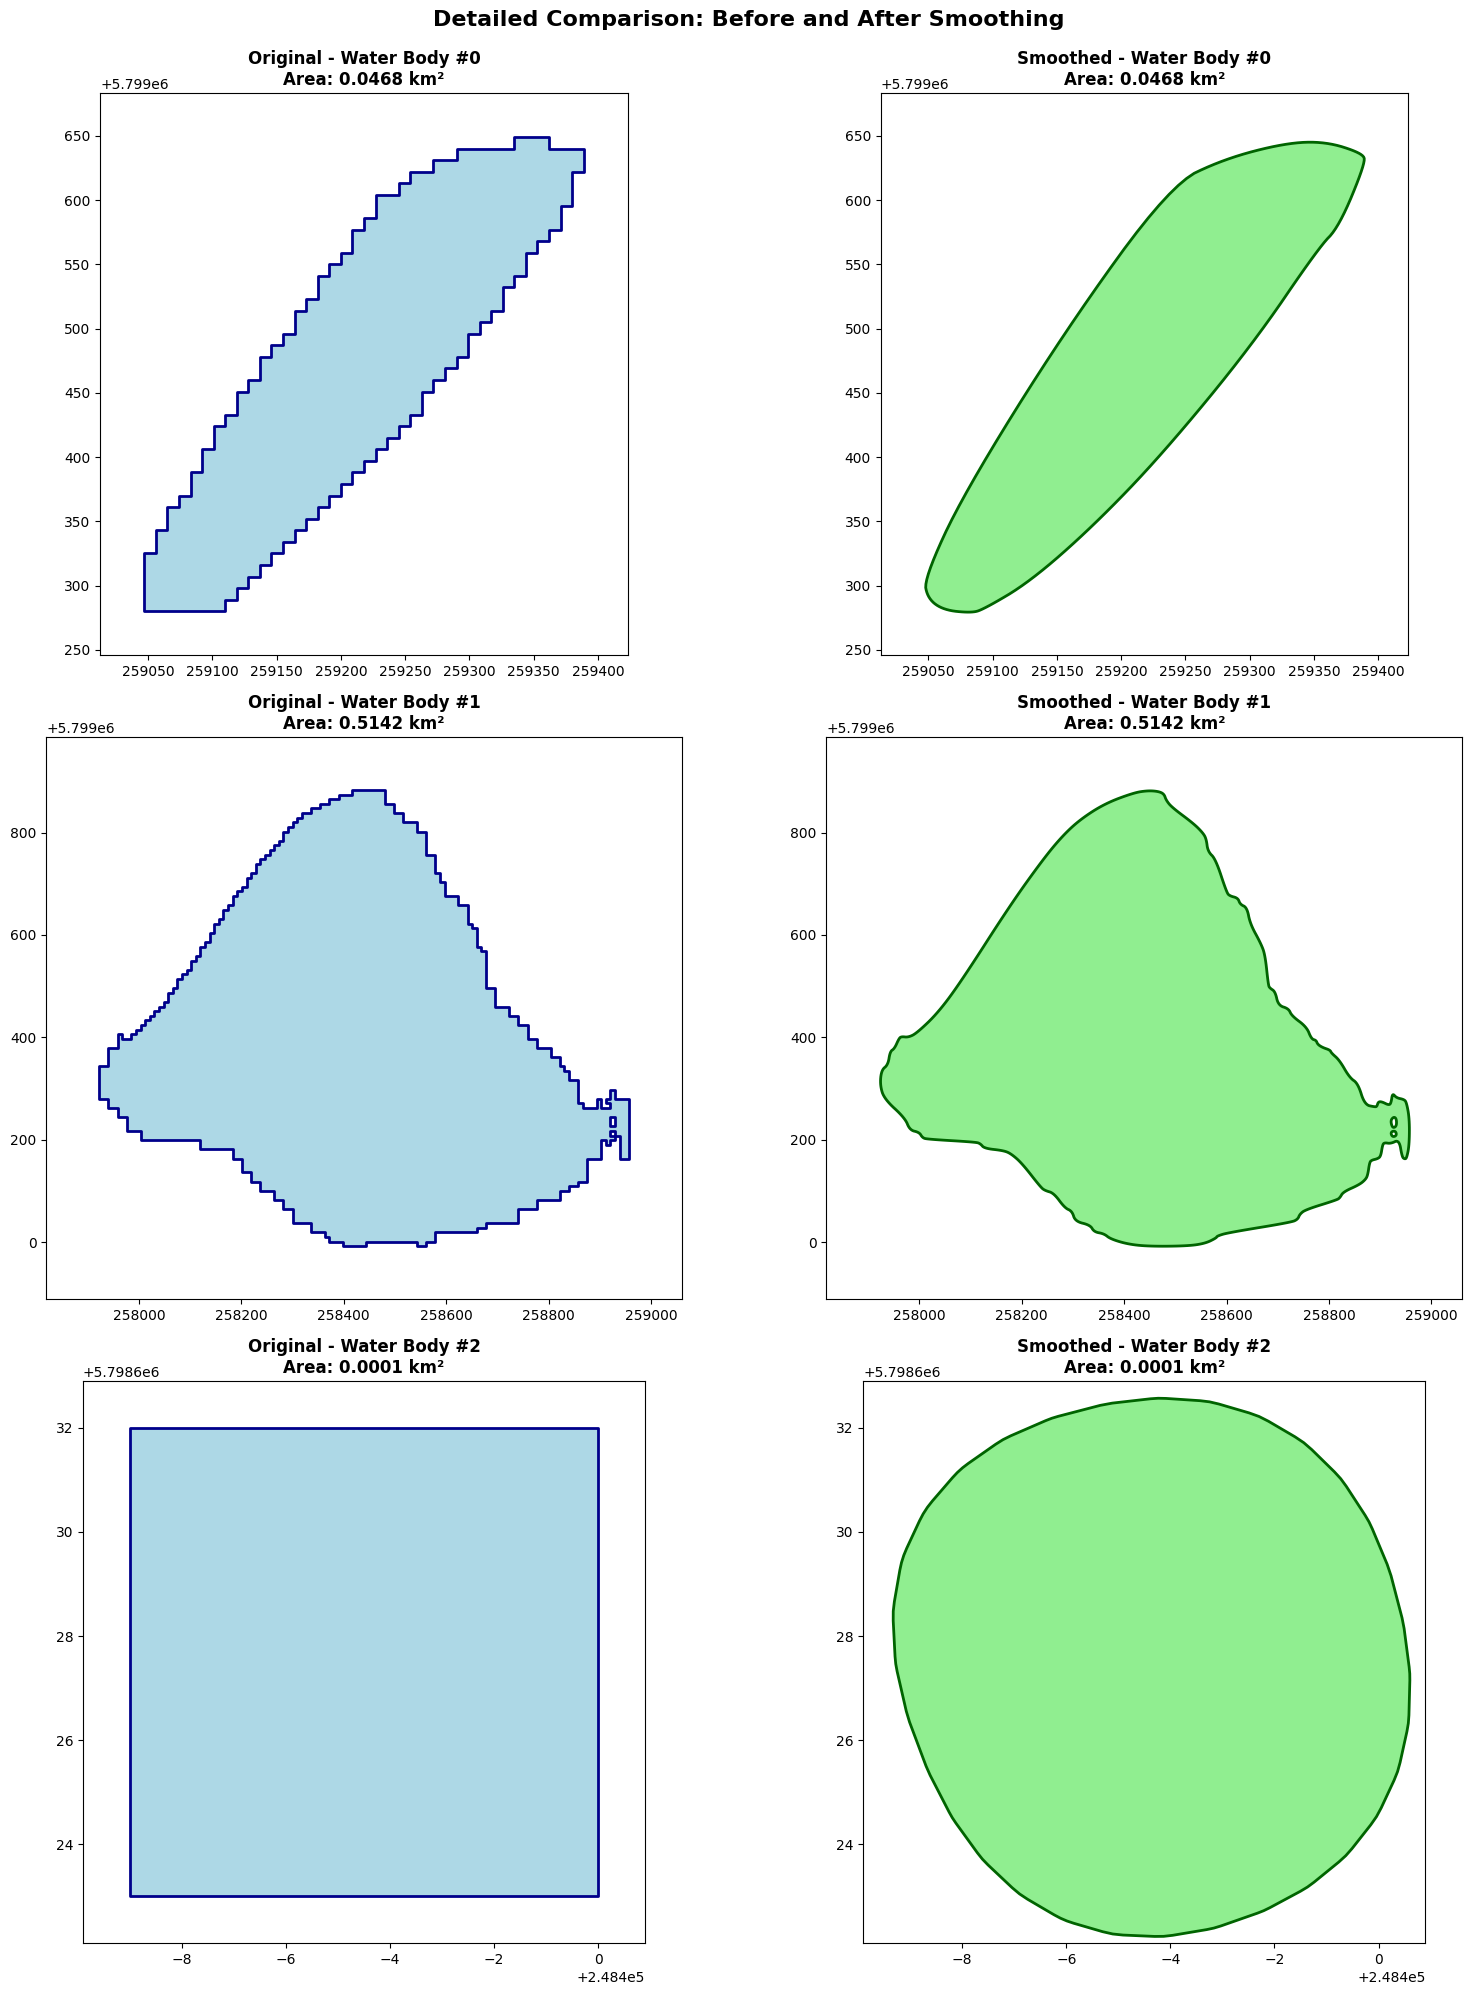

In [8]:
# Compare the same sample water bodies
sample_smoothed = smoothed_water_gdf.loc[sample_indices]

fig, axes = plt.subplots(3, 2, figsize=(16, 20))

for idx, ((i, orig_row), (_j, smooth_row)) in enumerate(
    zip(sample_water.iterrows(), sample_smoothed.iterrows(), strict=False)
):
    # Original
    ax_orig = axes[idx, 0]
    gpd.GeoSeries([orig_row.geometry]).plot(
        ax=ax_orig, color="lightblue", edgecolor="darkblue", linewidth=2
    )
    ax_orig.set_title(
        f"Original - Water Body #{i}\nArea: {orig_row.geometry.area / 1e6:.4f} km²",
        fontweight="bold",
    )
    ax_orig.set_aspect("equal")

    # Smoothed
    ax_smooth = axes[idx, 1]
    gpd.GeoSeries([smooth_row.geometry]).plot(
        ax=ax_smooth, color="lightgreen", edgecolor="darkgreen", linewidth=2
    )
    ax_smooth.set_title(
        f"Smoothed - Water Body #{i}\nArea: {smooth_row.geometry.area / 1e6:.4f} km²",
        fontweight="bold",
    )
    ax_smooth.set_aspect("equal")

    # Match the view extent
    bounds = orig_row.geometry.bounds
    margin = (bounds[2] - bounds[0]) * 0.1
    for ax in [ax_orig, ax_smooth]:
        ax.set_xlim(bounds[0] - margin, bounds[2] + margin)
        ax.set_ylim(bounds[1] - margin, bounds[3] + margin)

plt.suptitle(
    "Detailed Comparison: Before and After Smoothing",
    fontsize=16,
    fontweight="bold",
    y=0.995,
)
plt.tight_layout()
plt.show()

## Overlay Comparison

Let's overlay the original and smoothed geometries to see exactly how the boundaries changed.

/var/folders/v8/_5l7r2rn1j53md4m9p6vq3900000gp/T/ipykernel_85050/2755907595.py:32: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper right", fontsize=12)
/var/folders/v8/_5l7r2rn1j53md4m9p6vq3900000gp/T/ipykernel_85050/2755907595.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right", fontsize=12)


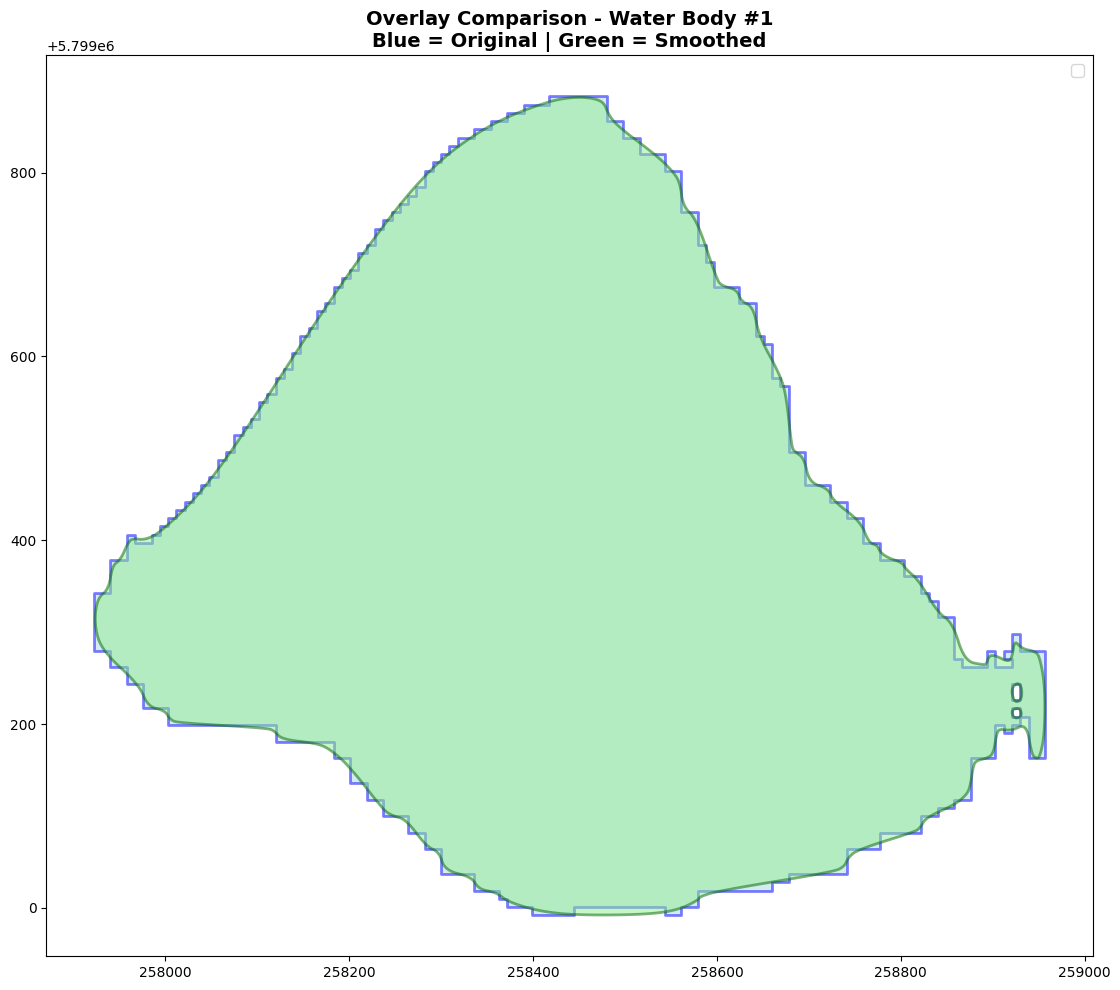

In [9]:
# Pick one large water body for detailed overlay
feature_idx = sample_indices[1]

fig, ax = plt.subplots(figsize=(12, 10))

# Plot original in blue
gpd.GeoSeries([water_gdf.loc[feature_idx].geometry]).plot(
    ax=ax,
    facecolor="lightblue",
    edgecolor="blue",
    linewidth=2,
    alpha=0.5,
    label="Original (Pixelated)",
)

# Plot smoothed in green
gpd.GeoSeries([smoothed_water_gdf.loc[feature_idx].geometry]).plot(
    ax=ax,
    facecolor="lightgreen",
    edgecolor="darkgreen",
    linewidth=2,
    alpha=0.5,
    label="Smoothed",
)

ax.set_title(
    f"Overlay Comparison - Water Body #{feature_idx}\nBlue = Original | Green = Smoothed",  # noqa: E501
    fontsize=14,
    fontweight="bold",
)
ax.set_aspect("equal")
ax.legend(loc="upper right", fontsize=12)
plt.tight_layout()
plt.show()

## Area Comparison: Original vs Smoothed

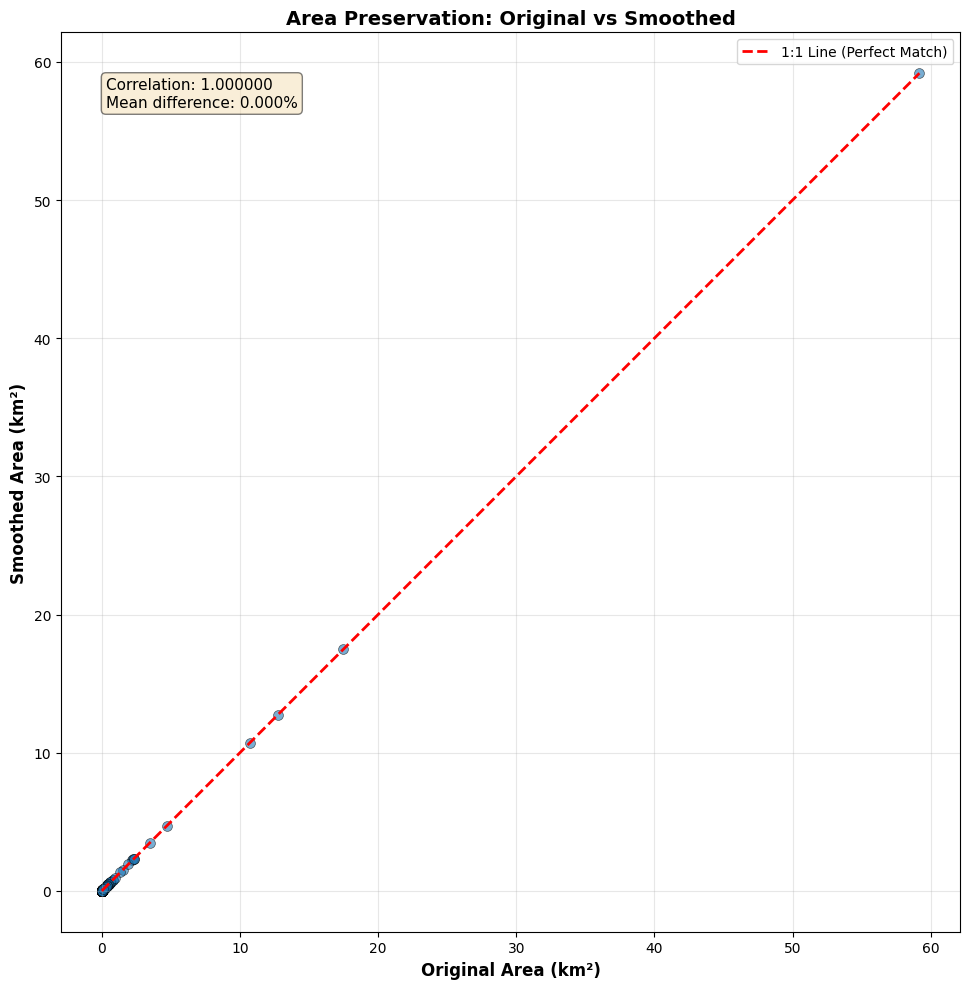

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

# Scatter plot of original vs smoothed area
original_areas = water_gdf.area / 1e6  # Convert to km²
smoothed_areas = smoothed_water_gdf.area / 1e6  # Convert to km²

ax.scatter(
    original_areas, smoothed_areas, alpha=0.6, s=50, edgecolors="black", linewidth=0.5
)

# Add 1:1 reference line
min_area = min(original_areas.min(), smoothed_areas.min())
max_area = max(original_areas.max(), smoothed_areas.max())
ax.plot(
    [min_area, max_area],
    [min_area, max_area],
    "r--",
    linewidth=2,
    label="1:1 Line (Perfect Match)",
)

ax.set_xlabel("Original Area (km²)", fontsize=12, fontweight="bold")
ax.set_ylabel("Smoothed Area (km²)", fontsize=12, fontweight="bold")
ax.set_title("Area Preservation: Original vs Smoothed", fontsize=14, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_aspect("equal", adjustable="box")


correlation = pearsonr(original_areas, smoothed_areas)[0]
mean_diff_pct = ((smoothed_areas - original_areas) / original_areas * 100).mean()

textstr = f"Correlation: {correlation:.6f}\nMean difference: {mean_diff_pct:.3f}%"
ax.text(
    0.05,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=11,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

plt.tight_layout()
plt.show()

## Export Smoothed Data

Save the smoothed water bodies to a new GeoPackage file.

In [11]:
# Save to new GeoPackage
output_file = "Water_Smoothed.gpkg"
smoothed_water_gdf.to_file(output_file, driver="GPKG")

## Experiment: Parameter Grid - Smoothing Iterations vs Segment Length

Let's explore how different combinations of `smooth_iterations` and `segment_length` affect the smoothing result on a real water body from the dataset.

Selected water body #1
  Original area: 0.5142 km²
  Perimeter: 4.21 km
  Vertices: 225


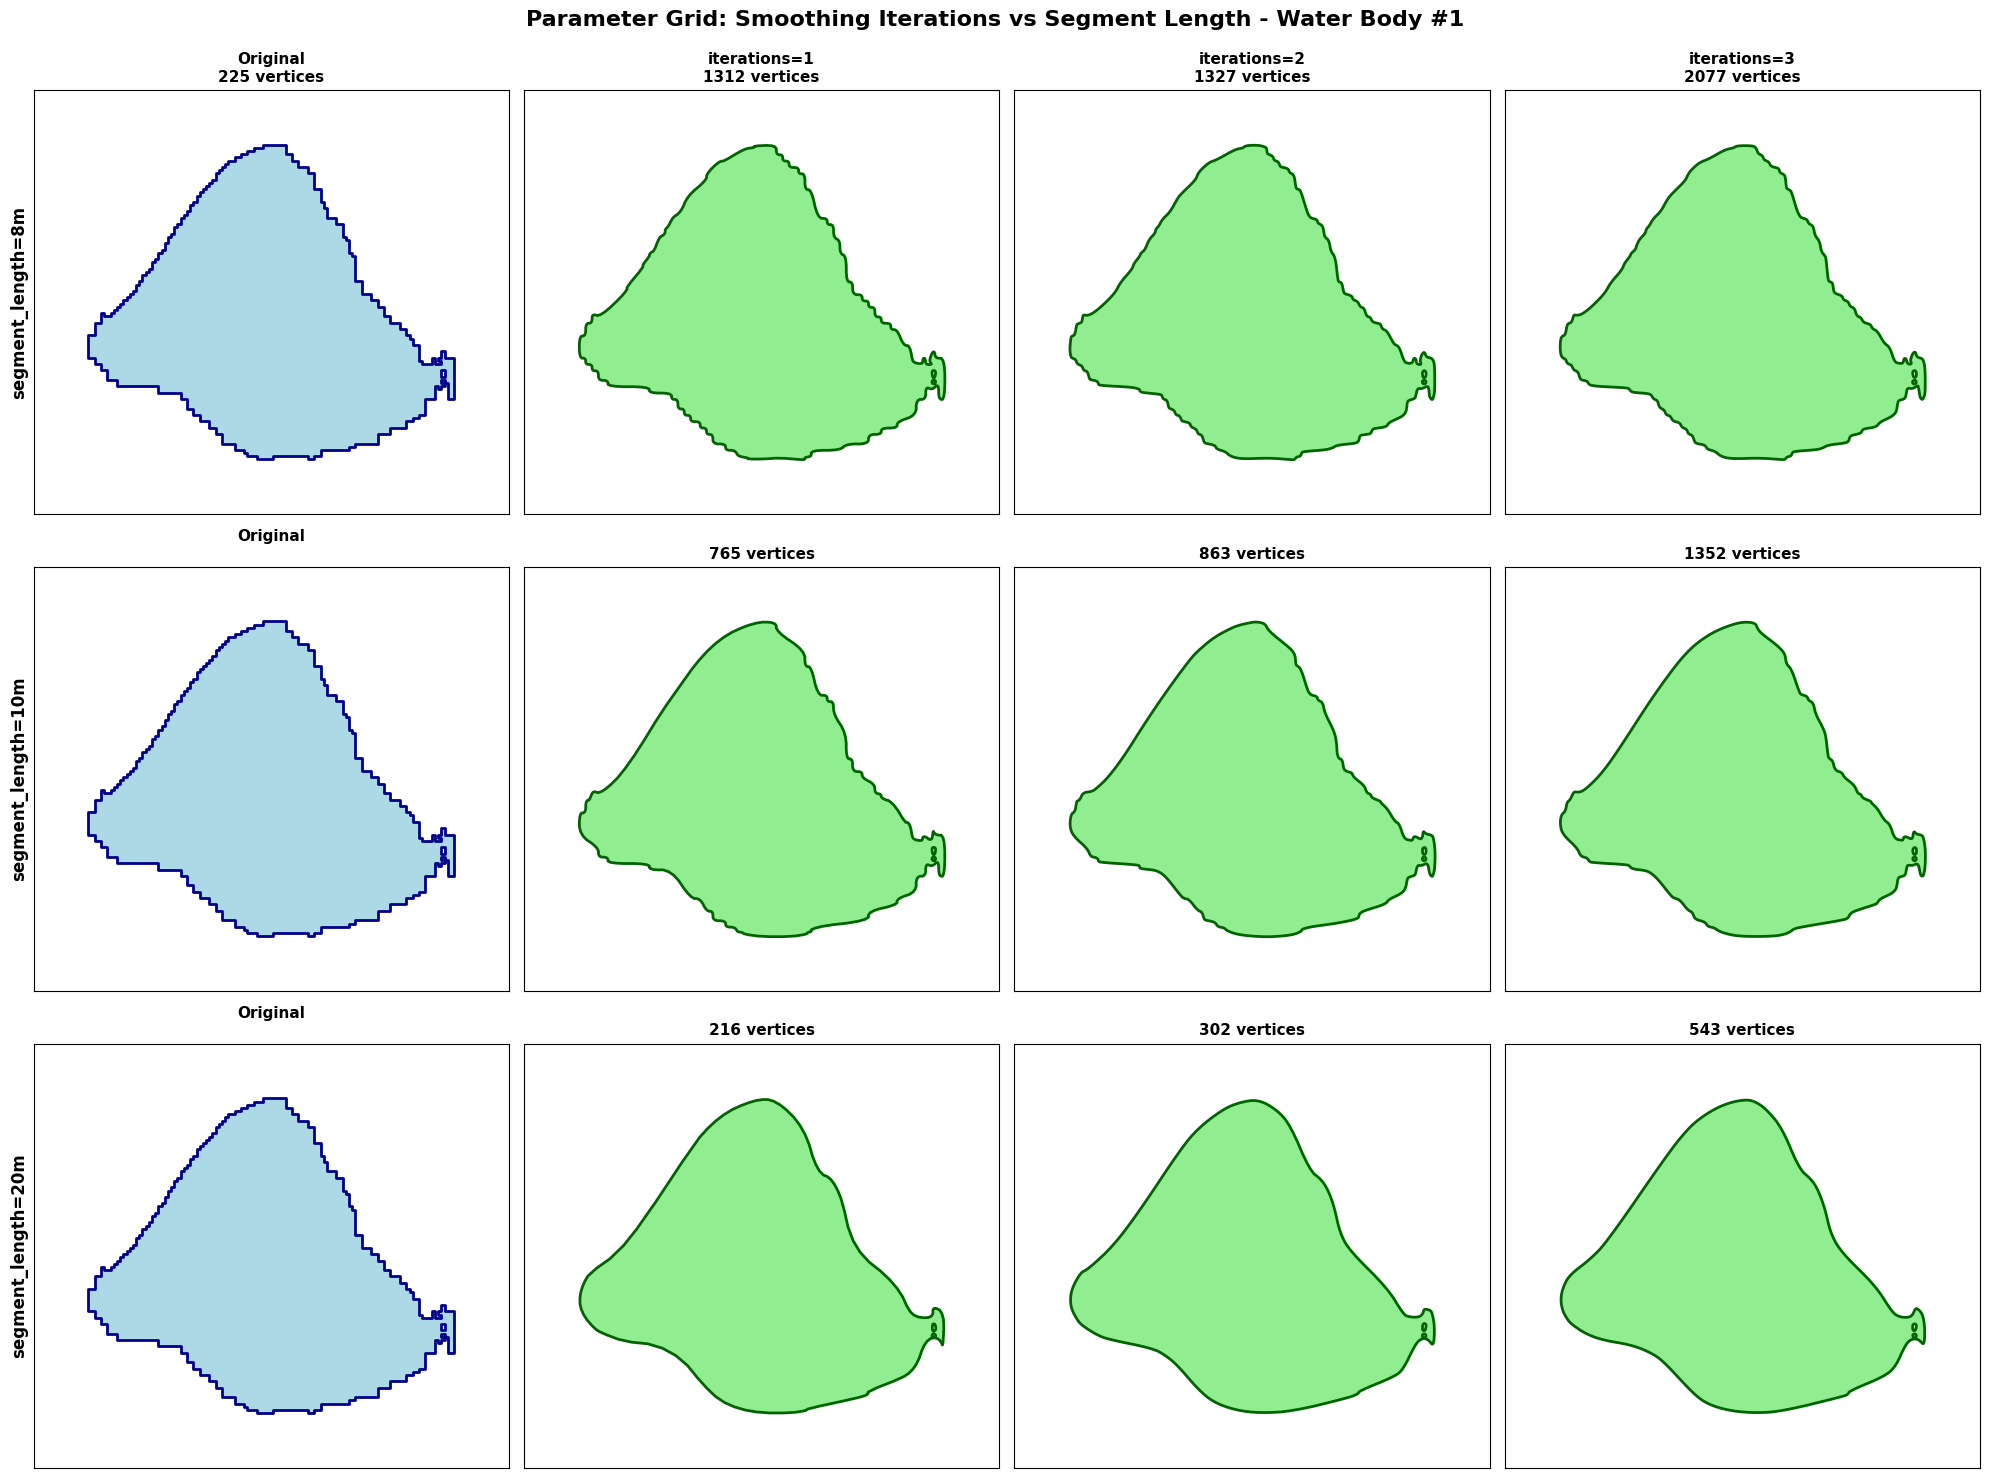


PARAMETER GRID SUMMARY
Segment Length     Iterations   Vertices     Perimeter (km) 
--------------------------------------------------------------------------------
Original           -            225          4.212          
--------------------------------------------------------------------------------
8                  1            1312         3.396          
8                  2            1327         3.261          
8                  3            2077         3.240          
--------------------------------------------------------------------------------
10                 1            765          3.261          
10                 2            863          3.171          
10                 3            1352         3.154          
--------------------------------------------------------------------------------
20                 1            216          3.090          
20                 2            302          3.052          
20                 3            543       

In [12]:
# Select an interesting water body with clear pixelated edges
# We'll pick one from the larger features that will show the smoothing effect well
test_feature_idx = sample_indices[1]  # Use the second largest from our earlier samples
test_feature = water_gdf.loc[test_feature_idx].geometry

print(f"Selected water body #{test_feature_idx}")
print(f"  Original area: {test_feature.area / 1e6:.4f} km²")
print(f"  Perimeter: {test_feature.length / 1000:.2f} km")
print(f"  Vertices: {len(test_feature.exterior.coords)}")

# Define parameter grid
smooth_iterations_list = [1, 2, 3]
segment_lengths = [8, 10, 20]

# Create grid of results
results_grid = {}
for seg_len in segment_lengths:
    for smooth_iter in smooth_iterations_list:
        smoothed = smoothify(
            geom=test_feature,
            segment_length=float(seg_len),
            smooth_iterations=smooth_iter,
            preserve_area=True,
        )
        results_grid[(seg_len, smooth_iter)] = smoothed

# Visualize as a grid
fig, axes = plt.subplots(
    len(segment_lengths), len(smooth_iterations_list) + 1, figsize=(20, 15)
)

# Plot original in first column for each row
for row_idx, seg_len in enumerate(segment_lengths):
    ax = axes[row_idx, 0]
    gpd.GeoSeries([test_feature]).plot(
        ax=ax, color="lightblue", edgecolor="darkblue", linewidth=2
    )

    if row_idx == 0:
        title = f"Original\n{len(test_feature.exterior.coords)} vertices"
    else:
        title = "Original\n "

    ax.set_title(title, fontweight="bold", fontsize=11)
    ax.set_aspect("equal")
    ax.set_ylabel(f"segment_length={seg_len}m", fontweight="bold", fontsize=12)

# Plot smoothed versions in grid
for row_idx, seg_len in enumerate(segment_lengths):
    for col_idx, smooth_iter in enumerate(smooth_iterations_list):
        ax = axes[row_idx, col_idx + 1]
        smoothed_geom = results_grid[(seg_len, smooth_iter)]

        gpd.GeoSeries([smoothed_geom]).plot(
            ax=ax, color="lightgreen", edgecolor="darkgreen", linewidth=2
        )

        # Add column header only in first row
        if row_idx == 0:
            title = f"iterations={smooth_iter}\n{len(smoothed_geom.exterior.coords)} vertices"  # noqa: E501
        else:
            title = f"{len(smoothed_geom.exterior.coords)} vertices"

        ax.set_title(title, fontweight="bold", fontsize=11)
        ax.set_aspect("equal")

# Match extents for all subplots
bounds = test_feature.bounds
margin = (bounds[2] - bounds[0]) * 0.15
for ax in axes.flat:
    ax.set_xlim(bounds[0] - margin, bounds[2] + margin)
    ax.set_ylim(bounds[1] - margin, bounds[3] + margin)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle(
    f"Parameter Grid: Smoothing Iterations vs Segment Length - Water Body #{test_feature_idx}",  # noqa: E501
    fontsize=16,
    fontweight="bold",
    y=0.995,
)
plt.tight_layout()
plt.show()

# Print detailed summary table
print("\n" + "=" * 80)
print("PARAMETER GRID SUMMARY")
print("=" * 80)
print(
    f"{'Segment Length':<18} {'Iterations':<12} {'Vertices':<12} {'Perimeter (km)':<15}"
)
print("-" * 80)
print(
    f"{'Original':<18} {'-':<12} {len(test_feature.exterior.coords):<12} {test_feature.length / 1000:<15.3f}"  # noqa: E501
)
print("-" * 80)

for seg_len in segment_lengths:
    for smooth_iter in smooth_iterations_list:
        geom = results_grid[(seg_len, smooth_iter)]
        print(
            f"{seg_len:<18} {smooth_iter:<12} {len(geom.exterior.coords):<12} {geom.length / 1000:<15.3f}"  # noqa: E501
        )
    if seg_len != segment_lengths[-1]:
        print("-" * 80)

print("\nKey Observations:")
print("  • Higher segment_length = more aggressive simplification (fewer vertices)")
print("  • Higher iterations = smoother curves (more vertices added)")
print("  • Area preservation remains excellent across all parameter combinations")